# EEG analysis

In [1]:
%matplotlib qt

import mne
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from utils import create_montage
path = "subjects/S001/S001R05.edf"
raw = mne.io.read_raw_edf(path, preload=True)
create_montage(raw)

Extracting EDF parameters from c:\Users\yassi\OneDrive\Documents\AI\MNE\subjects\S001\S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


## II. Filter and referencing

This part checks if there is any channels that need to be exclude

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


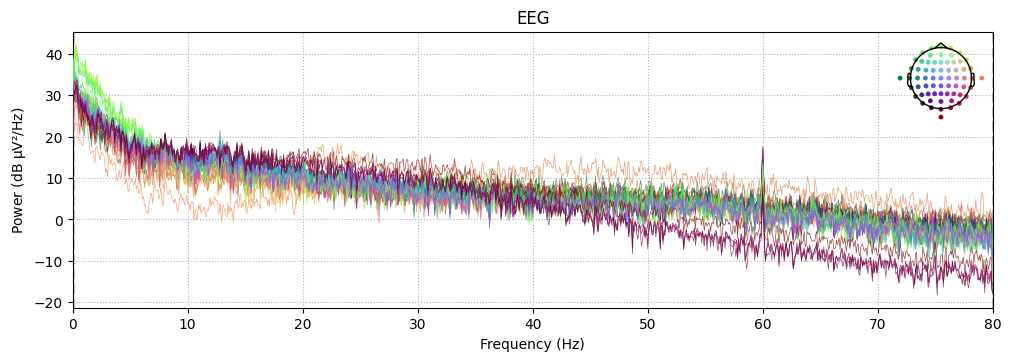

In [3]:
raw.compute_psd().plot()


In [4]:
print(raw.info['nchan'])
print(np.linalg.matrix_rank(raw.get_data()))

64
64


We filter our signals here to suppress artifacts. Our PSD plot showed no outliers in the channels, so we will not exclude any channels manually. However, we will use the maxwell function in order to chekc automatically.

In [5]:
import numpy as np

data = raw.get_data()
variances = np.var(data, axis=1)
threshold = np.mean(variances) + 3 * np.std(variances)
bad_idx = np.where(variances > threshold)[0]
bad_channels = [raw.ch_names[i] for i in bad_idx]
print(bad_channels)

['Fp1', 'Fp2', 'AF8']


Fp1, Fp2, and AF8 are positioned near the eyes. Since our subject blinks and alternates between eyes closed and open, the signals from these channels are likely contaminated by these movements.

In [6]:
raw.filter(1., 40., fir_design='firwin')

# Re-référencer à la moyenne des canaux EEG
raw.set_eeg_reference('average')

# Interpoler canaux mauvais
raw.info['bads'] = bad_channels  # example

raw.interpolate_bads()

# ICA suppression artefacts (ex. clignements)
from mne.preprocessing import ICA

ica = ICA(n_components=61, random_state=97)
ica.fit(raw)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


    Automatic origin fit: head of radius 98.4 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 61 components
Fitting ICA took 3.9s.


<ICA | raw data decomposition, method: fastica (fit in 92 iterations on 20000 samples), 61 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Using matplotlib as 2D backend.


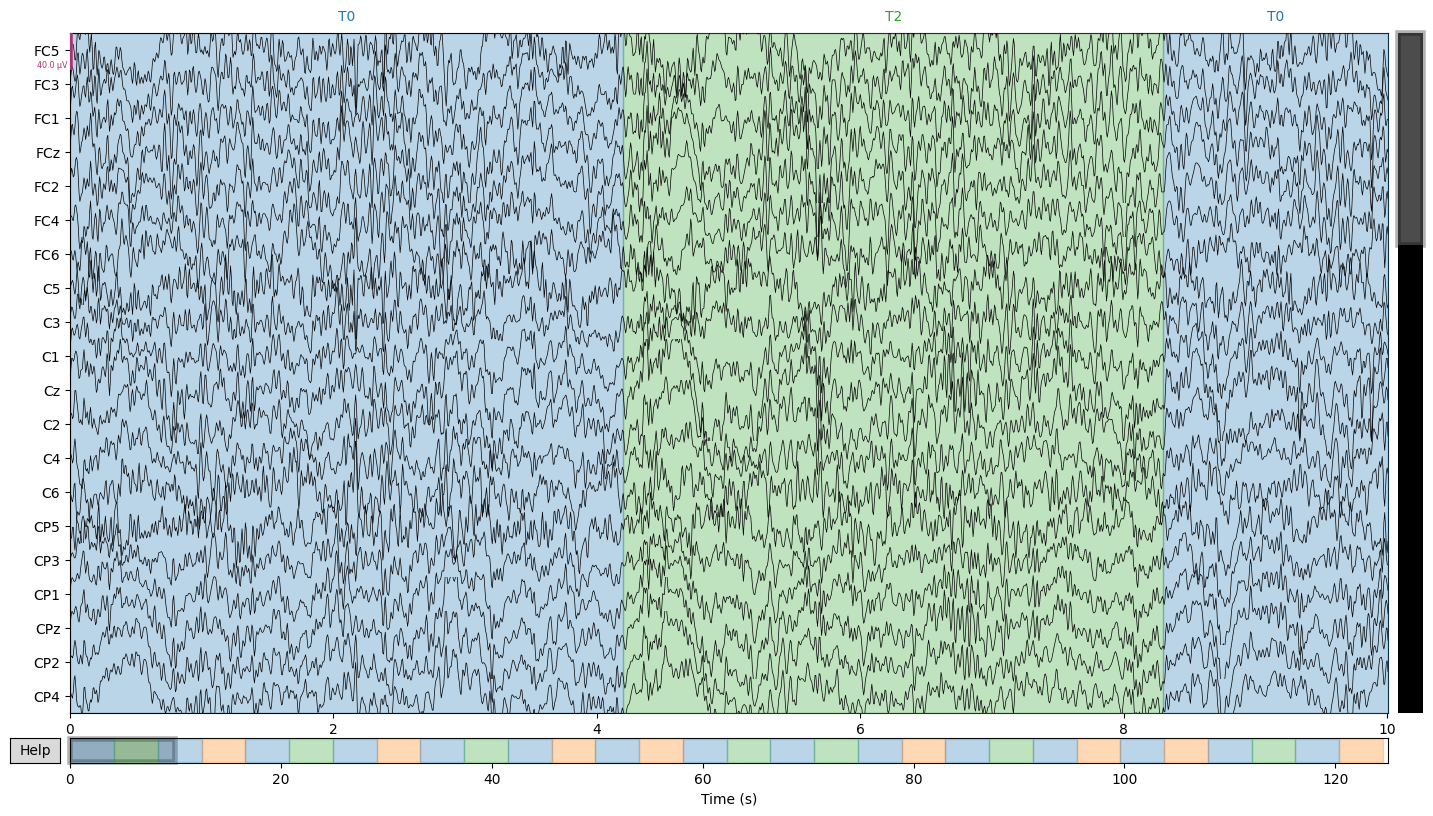

In [7]:
raw.plot()

## III. Epoch segmentation

We need to separate our EEG signals according to the events. We need to use the object *Epochs* for that.

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 161 original time points ...
1 bad epochs dropped


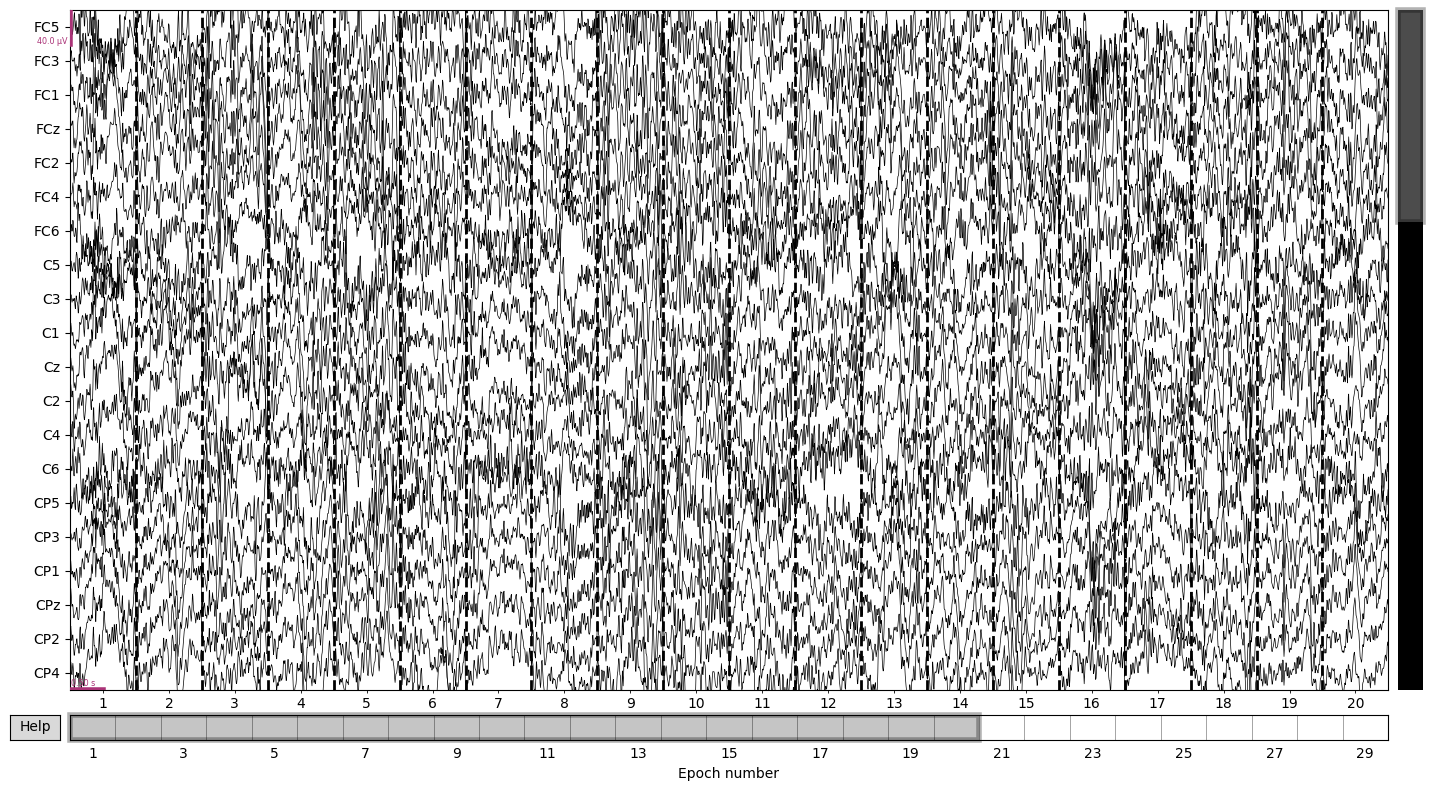

In [8]:
import pandas as pd

events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id=event_id,
                    tmin=-0.2, tmax=0.8, preload=True)
epochs.plot()


Note that we create 30 epochs.

## IV. Epoch vizualisation

In [9]:
import matplotlib.pyplot as plt
from mne.viz import plot_topomap


channel_means = {}
for condition in event_id:
    data = epochs[condition].get_data()  # (n_epochs, n_channels, n_times)
    mean_vals = data.mean(axis=0).mean(axis=1)  # mean over epochs and time, shape (n_channels,)
    channel_means[condition] = mean_vals

for cond, mean_values in channel_means.items():
    fig, ax = plt.subplots()
    plot_topomap(mean_values, epochs.info, axes=ax, show=False)
    ax.set_title(f'Mean amplitude - {cond}')
plt.show()

The  T0 activity looks abnormal. Let's analyze if we can supress residual artifacts with ICA in order to fix this.

## V. Statistical comparison between conditions

This code performs a non-parametric cluster-based permutation test to compare conditions statistically.

In [10]:
from mne.stats import permutation_cluster_test

# Extract data arrays for two conditions (n_epochs, n_channels, n_times)
data_cond1 = epochs['T0'].get_data()
data_cond2 = epochs['T1'].get_data()
data_cond3 = epochs['T2'].get_data()

# Average across time window or use data as is (select time range if needed)
data1 = data_cond1.mean(axis=2)  # shape (n_epochs, n_channels)
data2 = data_cond2.mean(axis=2)
data3 = data_cond3.mean(axis=2)

T_obs, clusters, cluster_pv, H0 = permutation_cluster_test([data1, data2, data3], n_permutations=1000)


Using a threshold of 3.369016


stat_fun(H1): min=0.04520589545394682 max=9.966008702439167
Running initial clustering …
Found 7 clusters


C:\Users\yassi\AppData\Local\Temp\ipykernel_6488\722561367.py:13: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_pv, H0 = permutation_cluster_test([data1, data2, data3], n_permutations=1000)
C:\Users\yassi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 999/999 [00:00<00:00, 4162.16it/s]


## VI. Removing artefacts with ICA

In [11]:
ica = ICA(n_components=20, random_state=97, method='fastica')
ica.fit(raw)
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2', "Fpz", "AF8"]) # No OEG so we use Fp1 and Fp1
indices_of_artifact_components = eog_indices


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 0.6s.
Using EOG channels: Fp1, Fp2, Fpz, AF8
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwid

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=20, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


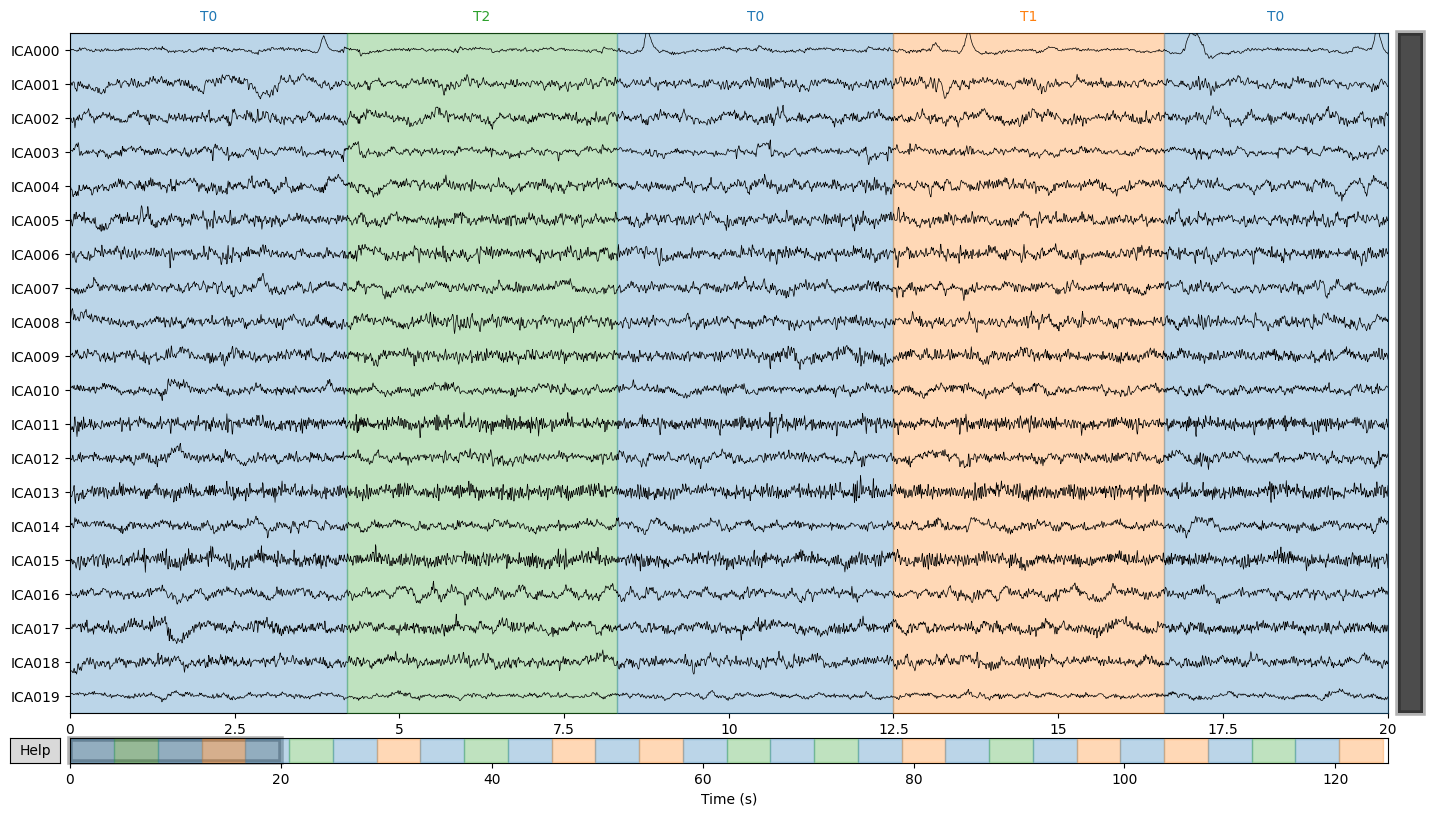

In [12]:
ica.plot_components()  # inspect spatial maps  
ica.plot_sources(raw)  # inspect time series  

In [13]:
ica.exclude = indices_of_artifact_components
raw_clean = ica.apply(raw.copy())


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


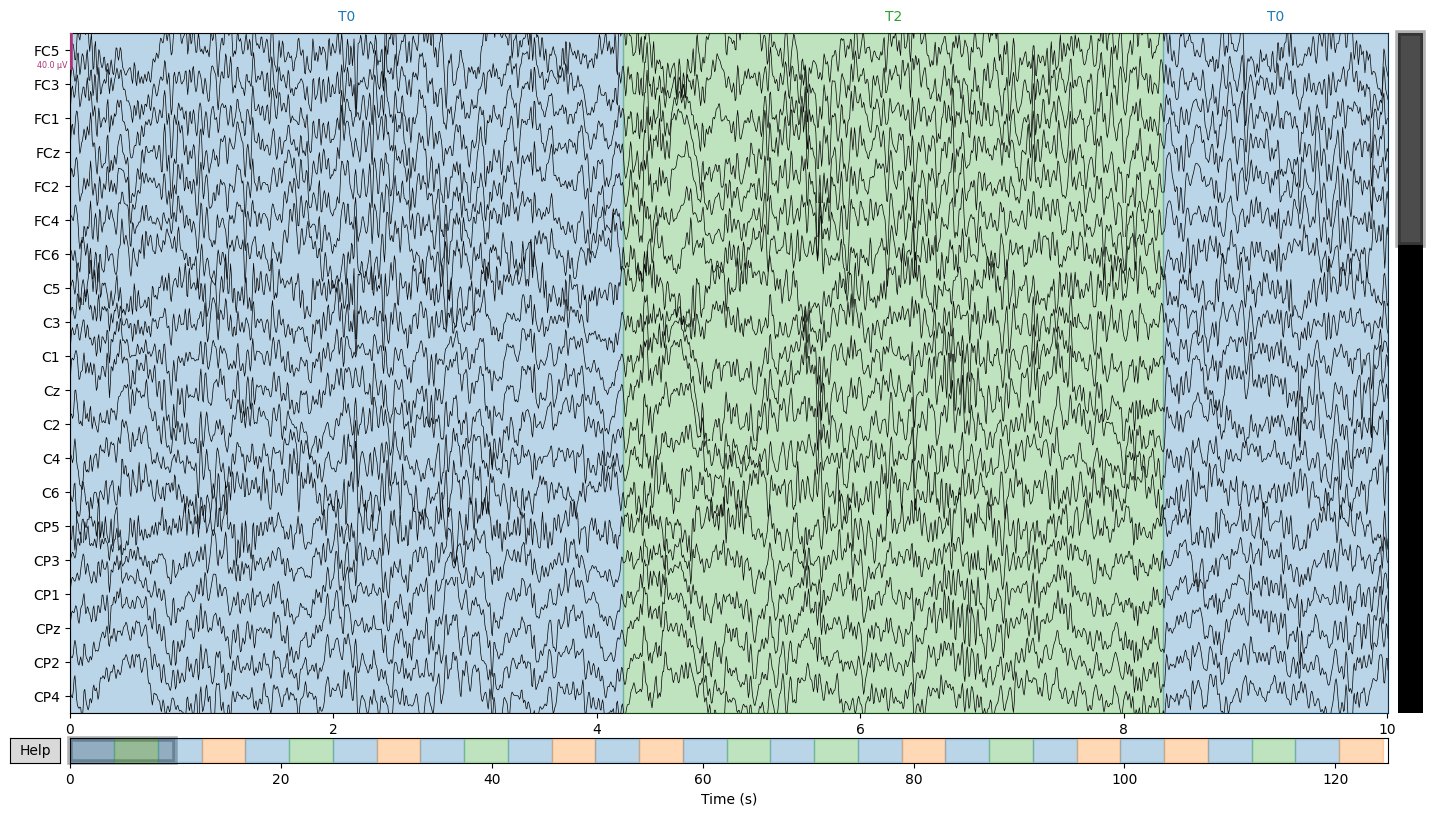

In [14]:
raw.plot(title='Original Raw Data')
raw_clean.plot(title='ICA Cleaned Raw Data')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


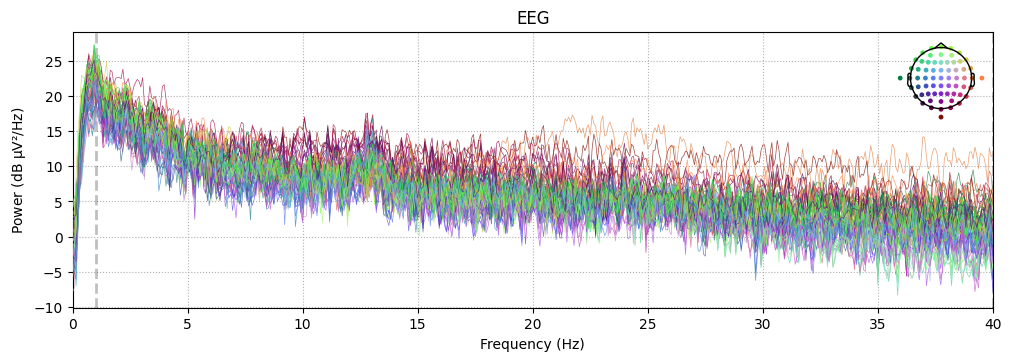

In [15]:
raw.plot_psd(fmax=40)
raw_clean.plot_psd(fmax=40)

Creating RawArray with float64 data, n_channels=20, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


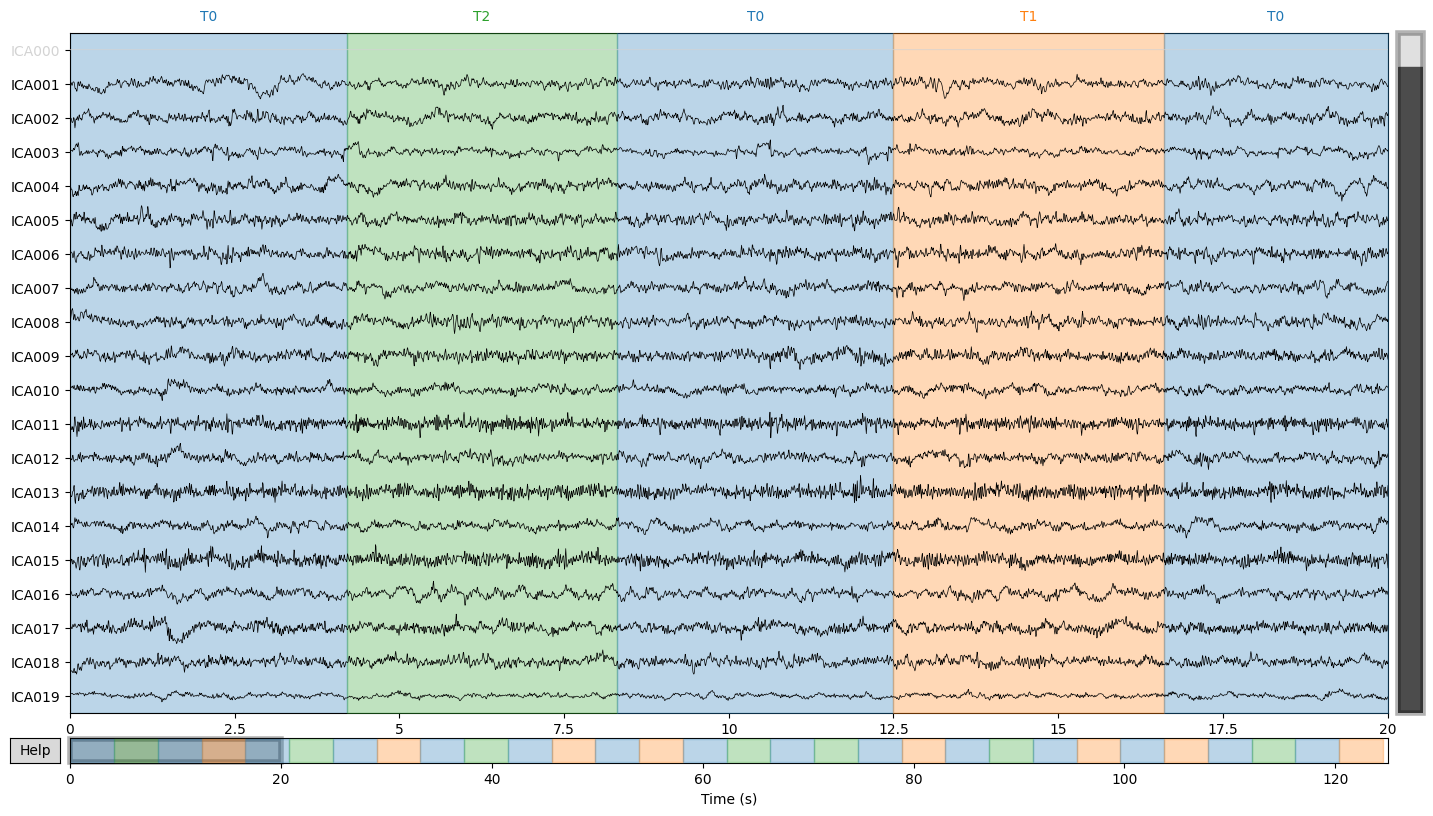

In [16]:
ica.plot_sources(raw)
ica.plot_sources(raw_clean)

## Rejecting bad epochs

In [17]:
reject_criteria = dict(eeg=250e-6)  # 150 µV peak-to-peak threshold
epochs_clean = epochs.copy().drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'O2', 'Iz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'O1', 'O2', 'Iz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'O2', 'Iz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2',

In [18]:
evokeds = {cond: epochs_clean[cond].average() for cond in event_id}
for cond, evoked in evokeds.items():
    evoked.plot(spatial_colors=True, time_unit='s', titles=cond)

Channels marked as bad:
none
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Channels marked as bad:
none


### 1. Cluster analysis

Testing clusters accounts for spatial-temporal correlation and reduces false positives compared to pointwise testing.

In [19]:
alpha = 0.05
sig_clusters = sum(p < alpha for p in cluster_pv)
print(f'Significant clusters: {sig_clusters} / {len(cluster_pv)}')
print('Cluster p-values:', cluster_pv)

Significant clusters: 3 / 7
Cluster p-values: [0.252 0.299 0.125 0.008 0.02  0.003 0.516]


Clusters that have a p value below 0.05 are kept. They are spatially contiguous groups of EEG channels that the permutation cluster test identified as showing significant differences between conditions. Let’s examine which channels correspond to these clusters.



In [20]:
for i_cluster, cluster in enumerate(clusters):
    ch_indices = cluster[0]  # cluster is a tuple of arrays; first element is channel indices
    ch_names = [epochs.ch_names[idx] for idx in ch_indices]
    print(f'Cluster {i_cluster} channels:', ch_names)

Cluster 0 channels: ['FC1', 'FCz']
Cluster 1 channels: ['C4']
Cluster 2 channels: ['CP5', 'CP3']
Cluster 3 channels: ['CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8']
Cluster 4 channels: ['F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6']
Cluster 5 channels: ['TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz']
Cluster 6 channels: ['Iz']


In [21]:
alpha = 0.05
for i, (cluster, p_val) in enumerate(zip(clusters, cluster_pv)):
    if p_val < alpha:
        cluster_mask = cluster[0]  # boolean mask (channels × times)
        channels_in_cluster = np.where(cluster_mask)[0]
        print(channels_in_cluster)
        data_plot = np.zeros_like(T_obs)
        data_plot[channels_in_cluster] = T_obs[channels_in_cluster]
        plot_topomap(data_plot, epochs.info, cmap='RdBu_r', outlines='head', show=True)
        plt.title(f'Cluster {i}, p = {p_val:.3f}')
        plt.show()

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [22]:
cluster_kept = clusters[2:5]

### 2. Extract cluster time courses (average over channels and time within cluster)
 

In [23]:
for i, cluster_mask in enumerate(cluster_kept):
    channels_in_cluster = np.where(cluster_mask[0])[0]
    channel_names = [epochs.ch_names[i] for i in channels_in_cluster]
    print(f'Cluster {i} channels:', channel_names)
    
    # Extract data for cluster channels, averaged over time
    data_all = np.concatenate([data1, data2, data3], axis=0)  # shape (n_epochs, n_channels)
    cluster_data = data_all[:, channels_in_cluster].mean(axis=1)  # mean over cluster channels per epoch
    
    print(f'Cluster {i} mean activation:', cluster_data.mean())
    
    # Plot evoked response for cluster channels (example with condition 'T1')
    ch_names_unique = list(dict.fromkeys(channel_names))
    evoked_cluster = evokeds['T1'].copy().pick(ch_names_unique)
    fig = evoked_cluster.plot()
    fig.suptitle(f'Cluster {i} evoked response')


Cluster 0 channels: ['FC5', 'FC3']
Cluster 0 mean activation: -3.178265453361171e-06
Cluster 1 channels: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1']
Cluster 1 mean activation: -1.6592352148543161e-06
Cluster 2 channels: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6']
Cluster 2 mean activation: -1.7944986149754008e-06
